In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from math import log
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from tqdm import tqdm
from multiprocessing import Pool

In [2]:
def parallelize(groups, func):
    num_workers = 16
    with Pool(num_workers) as p:
        return pd.concat(p.map(func, [group for name, group in groups])).sort_index()

In [3]:
df = pd.read_pickle('../data/watch_list_clean.pkl.xz')[['title', 'username', 'rating']]

In [4]:
df

,title,username,rating
0,Day Break Illusion: il sole penetra le illusioni,Ruth,3.0
1,Dog Days,Ruth,3.5
2,Dog Days',Ruth,3.0
3,Fantasista Doll,Ruth,2.5
4,Fate/Kaleid Liner Prisma Illya,Ruth,3.5
...,...,...,...
9205777,The Ancient Magus' Bride,Rutendo,5.0
9205778,The Disastrous Life of Saiki K.,Rutendo,5.0
9205779,The Seven Deadly Sins,Rutendo,5.0
9205780,The Seven Deadly Sins: Revival of The Commandm...,Rutendo,5.0


## Scale user ratings to their own rating behavior

### Remove Outliers ($\pm3\sigma$)

In [5]:
# def in_three_std(x):
#     return x.between(x.quantile(0.05), x.quantile(0.95)) == 1

# in_three_std_mask = parallelize(df.groupby('username')['user_rating'], in_three_std)

# df.loc[~in_three_std_mask]

# df = df.loc[in_three_std_mask].copy(deep=True)

### Standard Scaling (Mean/Std Scaling)

In [6]:
tmp = df.loc[df['username'] == 'Rutoki']

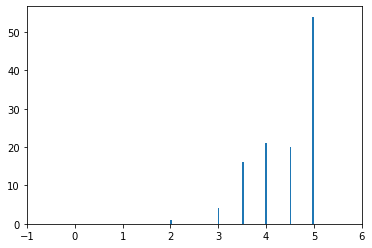

In [7]:
plt.hist(tmp['rating'], bins=100)
plt.xlim(-1, 6)
plt.show()

In [8]:
scaler = StandardScaler()
def user_rating_normalizer(group):
    scaled = scaler.fit_transform(group[['rating']])
    return pd.Series(scaled.reshape(1, scaled.shape[0])[0], index=group.index)

In [9]:
df['rating'] = parallelize(df.groupby('username'), user_rating_normalizer)

In [10]:
tmp = df.loc[df['username'] == 'Rutoki']

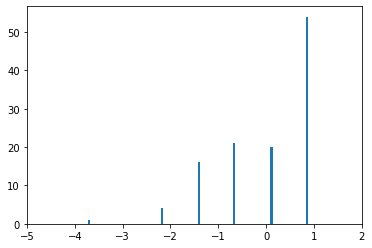

In [11]:
plt.hist(tmp['rating'], bins=100)
plt.xlim(-5, 2)
plt.show()

### Return ratings back to 0-5 scale

In [12]:
def sigmoid(x):
    z = np.exp(-x)
    sig = 1 / (1 + z)
    return sig

In [13]:
df['rating'] = sigmoid(df['rating']) * 5

## Convert ratings to binary
- 0: rating <= 0 ("did not like that much")
- 1: rating > 0 ("did like it")

df['rating'] = df['rating'].apply(lambda x: 1 if x > 0 else 0)

## Reshape

In [14]:
pivot = df.pivot(index='username', columns='title', values='rating')
pivot = pivot.sample(pivot.shape[0])

In [15]:
pivot.shape

(117162, 4489)

## Train-Validate-Test Split
- Train: 60%
- Validate: 20%
- Test: 20%

In [16]:
train = pivot.sample(frac=0.6, random_state=42)
pivot = pivot.drop(train.index)
validate = pivot.sample(frac=0.5, random_state=42)
test = pivot.drop(validate.index)

In [17]:
train.shape

(70297, 4489)

## Saving Data

In [18]:
train.to_pickle('../data/train.pkl')
validate.to_pickle('../data/validate.pkl')
test.to_pickle('../data/test.pkl')

In [19]:
%%bash
cd ../data

rm train.pkl.xz
xz -vT14 train.pkl

rm validate.pkl.xz
xz -vT14 validate.pkl

rm test.pkl.xz
xz -vT14 test.pkl

train.pkl: 16.5 MiB / 2,409.3 MiB = 0.007, 286 MiB/s, 0:08
validate.pkl: 6,036.0 KiB / 804.1 MiB = 0.007, 245 MiB/s, 0:03
test.pkl: 6,056.3 KiB / 804.1 MiB = 0.007, 245 MiB/s, 0:03


In [20]:
train.to_csv('../data/train.csv')
validate.to_csv('../data/validate.csv')
test.to_csv('../data/test.csv')

In [21]:
%%bash
cd ../data

rm train.csv.xz
xz -vT14 train.csv

rm validate.csv.xz
xz -vT14 validate.csv

rm test.csv.xz
xz -vT14 test.csv

train.csv: 14.5 MiB / 393.5 MiB = 0.037, 43 MiB/s, 0:09
validate.csv: 4,978.2 KiB / 131.0 MiB = 0.037, 35 MiB/s, 0:03
test.csv: 4,993.8 KiB / 131.3 MiB = 0.037, 34 MiB/s, 0:03
